* 逻辑斯特回归
* 正则化的逻辑斯特

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')


In [16]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ', data.shape)
    # 打印前5
    print(data[:5, :])
    return data

In [17]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # 获得正负样本的坐标
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1],  marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True)

## 逻辑斯特回归

In [18]:
data = loaddata('data1.txt', ',')

Dimensions:  (100, 3)
[[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]]


In [21]:
x = np.c_[np.ones((data.shape[0], 1)), data[:, 0:2]]
y = np.c_[data[:,2]]

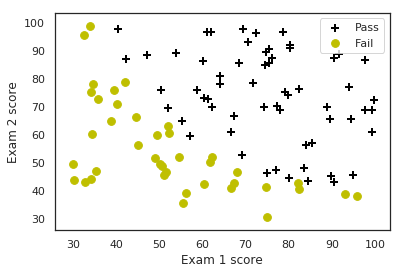

In [82]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Pass', 'Fail')

> Sigmoid函数是一个在生物学中常见的S型函数，也称为S型生长曲线。在信息科学中，
    由于其单增以及反函数单增等性质，Sigmoid函数常被用作神经网络的阈值函数，
    将变量映射到0,1之间。

![WX20181201-200141@2x.png](https://i.loli.net/2018/12/01/5c0278329b3ac.png)


In [23]:
# 定义sigmoid函数
def sigmoid(z):
    return (1/(1+np.exp(-z)))

## 损失函数
![WX20181201-214703@2x.png](https://i.loli.net/2018/12/01/5c0290e531577.png)
## 向量化的损失函数（矩阵形式）
![WX20181201-215423@2x.png](https://i.loli.net/2018/12/01/5c0292a65e7a5.png)


In [29]:
# 定义损失函数
def costFunction(theta, x,y):
    m = y.size
    h = sigmoid(x.dot(theta))
    J = -1.0*(1.0/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
    if np.isnan(J[0]):
        return np.inf
    return J[0]

![WX20181201-220144@2x.png](https://i.loli.net/2018/12/01/5c0294732e944.png)

In [30]:
# 求解梯度
def gradient(theta, x,y):
    m = y.size
    h = sigmoid(x.dot(theta.reshape(-1,1)))
    grad = (1.0/m)*x.T.dot(h-y)
    return grad.flatten()

In [31]:
initial_theta = np.zeros(x.shape[1])
cost = costFunction(initial_theta, x,y)
grad = gradient(initial_theta, x,y)
print('Cost: \n', cost)
print('Grad: \n', grad)

Cost: 
 0.6931471805599453
Grad: 
 [ -0.1        -12.00921659 -11.26284221]


In [34]:
# 最小损失函数
res = minimize(costFunction, initial_theta, args=(x,y), jac=gradient, options={'maxiter':400})
res

/Users/cuijl/.pyenv/versions/3.6.0/envs/rqalpha_3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/cuijl/.pyenv/versions/3.6.0/envs/rqalpha_3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


      fun: 0.2034977015895099
 hess_inv: array([[ 2.85339493e+03, -2.32908823e+01, -2.27416470e+01],
       [-2.32908823e+01,  2.04489131e-01,  1.72969525e-01],
       [-2.27416470e+01,  1.72969525e-01,  1.96170322e-01]])
      jac: array([-2.68557620e-09,  4.36433485e-07, -1.39671757e-06])
  message: 'Optimization terminated successfully.'
     nfev: 34
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([-25.16131634,   0.2062316 ,   0.20147143])

In [35]:
# 做预测
def predict(theta, x, threshold=0.5):
    p = sigmoid(x.dot(theta.T)) >= threshold
    return p.astype('int')

In [36]:
# 考试1得分45， 考试2得分85同学的概率有多高
sigmoid(np.array([1,45,85]).dot(res.x.T))

0.7762903249331021

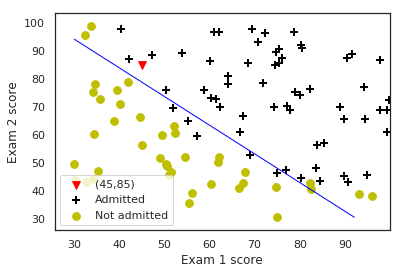

In [38]:
# 画决策边界
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45,85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = x[:,1].min(), x[:,1].max()
x2_min, x2_max = x[:,2].min(), x[:,2].max()
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), 
                       np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0], 1)),
                 xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')

## 加正则化项的逻辑斯特回归

In [40]:
data2 = loaddata('data2.txt', ',')

Dimensions:  (118, 3)
[[ 0.051267  0.69956   1.      ]
 [-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]]


In [43]:
# 拿到x,y
y = np.c_[data2[:,2]]
x = data2[:, 0:2]

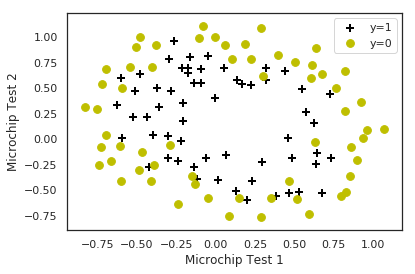

In [44]:
# 画图
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y=1', 'y=0')

In [45]:
# 多项式特征(最高6阶)
poly = PolynomialFeatures(6)
xx = poly.fit_transform(data2[:, 0:2])
xx.shape

(118, 28)

## 正则化损失函数
## 向量化的损失函数

In [72]:
# 定义损失函数
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(xx.dot(theta))
    J = -1.0*(1.0/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2.0*m))*np.sum(np.square(theta[1:]))
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

## 偏导（梯度）
## 向量化的偏导（梯度）

In [79]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(xx.dot(theta.reshape(-1,1)))
    grad = (1.0/m) * xx.T.dot(h-y) + (reg/m) * np.r_[[[0]],theta[1:].reshape(-1,1)]
    return(grad.flatten())

In [80]:
initial_theta = np.zeros(xx.shape[1])
costFunctionReg(initial_theta, 1, xx, y)

0.6931471805599454

/Users/cuijl/.pyenv/versions/3.6.0/envs/rqalpha_3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


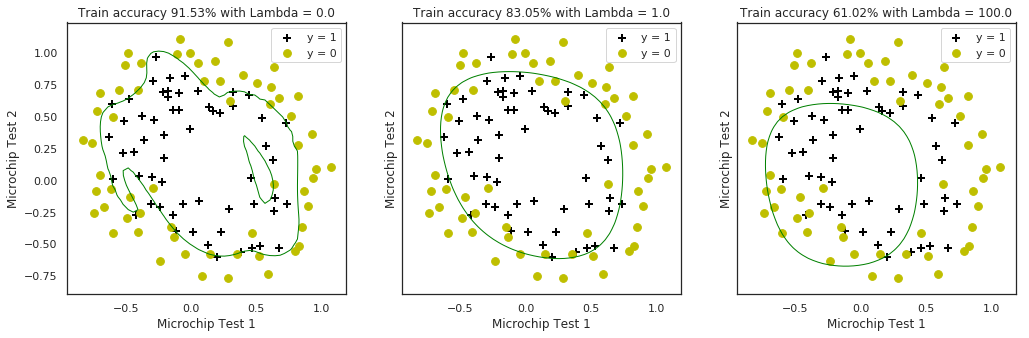

In [81]:
fig, axes = plt.subplots(1,3, sharey= True, figsize=(17, 5))
for i,C in enumerate([0.0, 1.0, 100.0]):
    # 最优化    
    res2 = minimize(costFunctionReg, initial_theta, args=(C, xx, y), jac=gradientReg, options={'maxiter':3000})

    # 准确率
    accuracy = 100.0 * sum(predict(res2.x, xx) == y.ravel())/y.size
   # 对X,y的散列绘图
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # 画出决策边界
    x1_min, x1_max = x[:,0].min(), x[:,0].max(),
    x2_min, x2_max = x[:,1].min(), x[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))